In [16]:
from torchvision import datasets
from matplotlib import pyplot as plt

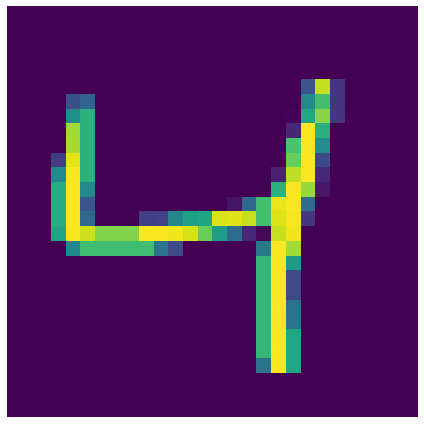

In [22]:

mnist = datasets.MNIST('data', train=True, download=True)


fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.imshow(mnist[2][0])
ax.axis('off')
plt.tight_layout()

In [ ]:
# fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

# ax[0].imshow(out1)
# ax[1].imshow(out2)

# for a in ax:
#     a.axis('off')
